Plot fit error distributions from different model fits to Baker et al data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import record_0_main as rcd_0
import record_1_ma_ext as rcd_1
import record_2_lin_ln as rcd_2

from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NNRN = 224

In [2]:
MDLS_META = {
    'ma': ('k', 'baker_ma.npy', rcd_0.smlt_ma),
    # 'lnma': ('m', 'baker_ma.npy', rcd_0.smlt_lnma),
    'linma': ('b', 'baker_ma.npy', rcd_0.smlt_linma),
    
    # 'lin': ('b', 'baker_lin.npy', rcd_2.smlt_lin),
    'linr': ('b', 'baker_linr.npy', rcd_2.smlt_linr),
    
    # 'ln': ('m', 'baker_ln.npy', rcd_2.smlt_ln),
    'lnr': ('m', 'baker_lnr.npy', rcd_2.smlt_lnr),
    'lnma_tweaked': ('m', 'baker_lnma_tweaked.npy', rcd_2.smlt_lnma_tweaked),
    # 'lnr_relu': ('m', 'baker_lnr_relu.npy', rcd_2.smlt_lnr_relu),
    # 'lnr_relu_flex': ('m', 'baker_lnr_relu_flex.npy', rcd_2.smlt_lnr_relu_flex),
    
    # 'ma_ind_ta': ('c', 'baker_ma_ind_ta.npy', rcd_1.smlt_ma_ind_ta),
}

In [3]:
df_s = pd.read_csv('data/simple/neur/baker_resampled_s.csv')
df_p = pd.read_csv('data/simple/neur/baker_resampled_p.csv')

In [4]:
T = np.array(df_s['T'])
I_S = np.array(df_s['S'])
I_P = np.array(df_p['P'])

R_SS = np.array(df_s[[f'R_{cnrn}' for cnrn in range(NNRN)]])
R_PS = np.array(df_p[[f'R_{cnrn}' for cnrn in range(NNRN)]])

In [5]:
r_mdl_ss_all = {}
r_mdl_ps_all = {}

for mdl, (color, fname, smlt) in MDLS_META.items():
    path = os.path.join('data/simple/neur/', fname)
    params = np.load(path, allow_pickle=True)[0]
    
    r_mdl_ss = smlt(I_S, 0*I_P, params, DT)
    r_mdl_ss_all[mdl] = r_mdl_ss
    
    r_mdl_ps = smlt(0*I_S, I_P, params, DT)
    r_mdl_ps_all[mdl] = r_mdl_ps

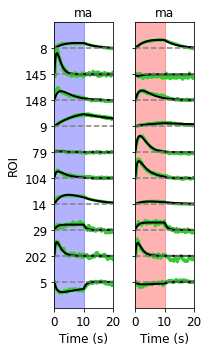

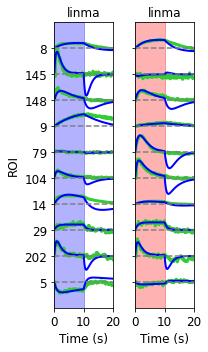

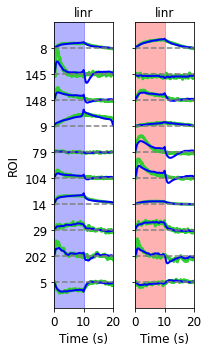

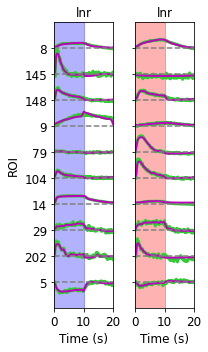

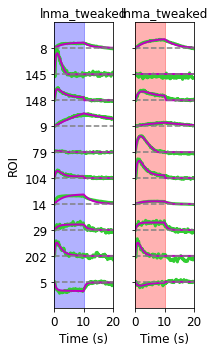

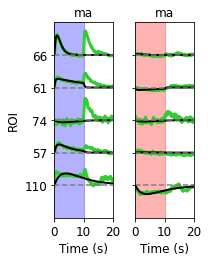

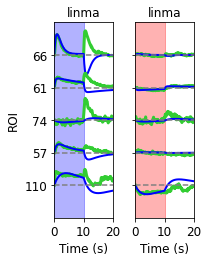

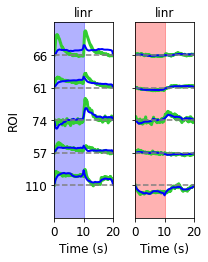

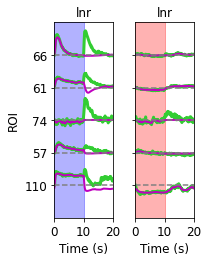

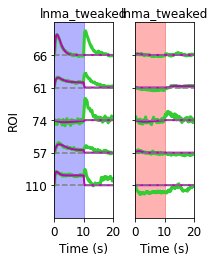

In [6]:
nrns_plot_all = [
    # [8, 9, 17, 22, 24, 29, 49, 77, 79, 104, 112, 119, 145, 4, 5, 114, 14, 202, 146],  # main examples
    # [8, 9, 104, 112, 24, 14, 29, 202, 5, 146],  # main examples
    [8, 145, 148, 9, 79, 104, 14, 29, 202, 5],  # main examples
    [66, 61, 74, 57, 110],
]
sfxs = ['', '_offset']
y_scale_plots = [.5, .75]

for nrns_plot, sfx, y_scale_plot in zip(nrns_plot_all, sfxs, y_scale_plots):
    nplot = len(nrns_plot)

    for mdl, (color, fname, smlt) in MDLS_META.items():
        fig, axs = plt.subplots(1, 2, figsize=(3, nplot*y_scale_plot), tight_layout=True, sharey=True)

        y_ticks = []

        for cnrn, inrn in enumerate(nrns_plot):
            y_tick = -4*cnrn

            axs[0].plot(T, R_SS[:, inrn]/2+y_tick, c='limegreen', lw=3)
            axs[0].plot(T, r_mdl_ss_all[mdl][:, inrn]/2 +y_tick, color=color, lw=2)

            axs[0].axhline(y_tick, c='gray', ls='--')

            axs[1].plot(T, R_PS[:, inrn]/2+y_tick, c='limegreen', lw=3)
            axs[1].plot(T, r_mdl_ps_all[mdl][:, inrn]/2 +y_tick, color=color, lw=2)

            axs[1].axhline(y_tick, c='gray', ls='--')

            y_ticks.append(y_tick)

        axs[0].axvspan(0, 10, color='b', alpha=.3)
        axs[1].axvspan(0, 10, color='r', alpha=.3)

        set_plot(axs[0], x_lim=(-.1, 20.1), y_lim=(-4*nplot, 4), x_ticks=[0, 10, 20], y_ticks=y_ticks, y_tick_labels=nrns_plot, x_label='Time (s)', y_label='ROI', title=mdl, font_size=12)
        set_plot(axs[1], x_lim=(-.1, 20.1), y_lim=(-4*nplot, 4), x_ticks=[0, 10, 20], x_label='Time (s)', title=mdl, font_size=12)

        fig.savefig(f'ms/1_{mdl}_xpl_fits{sfx}.svg')

In [7]:
def coef_det(y, y_hat, axis=0):
    rss = np.nansum((y_hat-y)**2, axis)
    tss = np.nansum(y**2, axis)
    return 1 - rss/tss

r2s = {}
sq_errs = {}

for mdl in MDLS_META:
    r_mdl_ss = r_mdl_ss_all[mdl]
    r_mdl_ps = r_mdl_ps_all[mdl]
    
    r2s[mdl] = coef_det(
        cc([R_SS, R_PS], axis=0),
        cc([r_mdl_ss, r_mdl_ps], axis=0),
        axis=0)
    
    sq_err_s = np.nanmean((r_mdl_ss - R_SS)**2, axis=0)
    sq_err_p = np.nanmean((r_mdl_ps - R_PS)**2, axis=0)
    
    sq_errs[mdl] = (sq_err_s+sq_err_p)/2

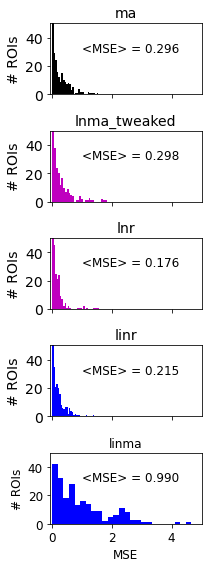

In [8]:
fig, axs = plt.subplots(len(MDLS_META), 1, figsize=(3, 8), sharex=True, tight_layout=True)
for ax, mdl in zip(axs, ['ma', 'lnma_tweaked', 'lnr', 'linr', 'linma']):
    ax.hist(sq_errs[mdl], bins=30, color=MDLS_META[mdl][0])
    mn_sq_err = np.mean(sq_errs[mdl])
    ax.text(1, 30, f'<MSE> = {mn_sq_err:.3f}', fontsize=12)
    ax.set_ylim(top=50)
    ax.set_xlim(right=5)
    set_plot(ax, y_label='# ROIs', title=f'{mdl}', font_size=14)
    if ax is axs[-1]:
        set_plot(ax, x_label='MSE')
    
# fig.savefig('supp/2_mse_ma_ln_lin.svg')

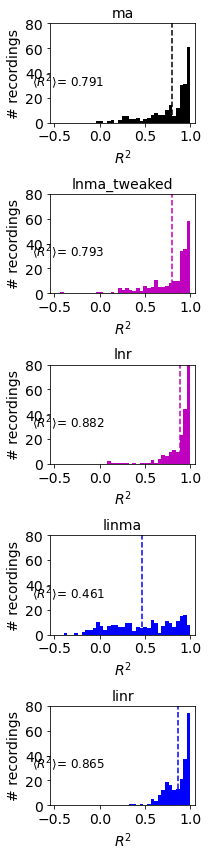

In [19]:
bins = np.linspace(-1, 1, 51)
fig, axs = plt.subplots(len(MDLS_META), 1, figsize=(3, 12), tight_layout=True)
for ax, mdl in zip(axs, ['ma', 'lnma_tweaked', 'lnr', 'linma', 'linr']):
    ax.hist(r2s[mdl], bins=bins, color=MDLS_META[mdl][0])
    mn_r2 = np.mean(r2s[mdl])
    ax.set_ylim(top=80)
    ax.axvline(mn_r2, color=MDLS_META[mdl][0], ls='--')
    ax.text(-.75, 30, r'$\langle R^2 \rangle$' + f'= {mn_r2:.3f}', fontsize=12)
    set_plot(ax, x_lim=(-.55, 1.05), x_label=r'$R^2$', y_label='# recordings', title=f'{mdl}', font_size=14)
    
fig.savefig('ms/1_r2_across_neurons.svg')